In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec



# Two levels that are used to create mean analysis

analysis_levels  = [6,17,28]
analysis_levels  = [13,26,43]

# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])


plevels = [85000, 60000, 30000]

# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = 22
    fhour     = int(filename[-1][0:2])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def open_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'], parallel=True)



In [48]:
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf3_dir  = str(os.path.join(in_dir, "WRF_km3_dt15", shear))
wrf4_dir  = str(os.path.join(in_dir, "WRF_km4_dt15", shear))
fv3A_dir = str(os.path.join(in_dir, "FV3_dt20_hord5", shear))
fv3B_dir = str(os.path.join(in_dir, "FV3_dt20_hord6", shear))

# Open data sets

wrf3  = open_mfdataset_list(wrf3_dir , "wrfout*")
wrf4  = open_mfdataset_list(wrf4_dir , "wrfout*")
fv3A  = open_mfdataset_list(fv3A_dir, "*.nc")
fv3B  = open_mfdataset_list(fv3B_dir, "*.nc")

fv3A_precip   = np.nan_to_num(fv3A.PREC_ACC_NC.isel(time=0).values).astype('float64')
wrf4_acc_prec = np.nan_to_num(wrf4.RAINNC.values).astype('float64')
fv3B_precip   = np.nan_to_num(fv3B.PREC_ACC_NC.isel(time=0).values).astype('float64')
wrf3_acc_prec = np.nan_to_num(wrf3.RAINNC.values).astype('float64')






In [78]:
def sum_cond(ds, Time='time'):
    if Time == 'time':
        return  np.nan_to_num(ds.QCLOUD.isel(time=0).values)  \
              + np.nan_to_num(ds.QRAIN.isel(time=0).values)   \
              + np.nan_to_num(ds.QICE.isel(time=0).values)    \
              + np.nan_to_num(ds.QSNOW.isel(time=0).values)   \
              + np.nan_to_num(ds.QGRAUPEL.isel(time=0).values) 
    else:
        return  np.nan_to_num(ds.QCLOUD.isel(Time=0).values)  \
              + np.nan_to_num(ds.QRAIN.isel(Time=0).values)   \
              + np.nan_to_num(ds.QICE.isel(Time=0).values)    \
              + np.nan_to_num(ds.QSNOW.isel(Time=0).values)   \
              + np.nan_to_num(ds.QHAIL.isel(Time=0).values) 

fv3A_cond     = sum_cond(fv3A)
fv3B_cond     = sum_cond(fv3B)
wrf3_cond     = sum_cond(wrf3, Time = 'Time')
wrf4_cond     = sum_cond(wrf4, Time = 'Time')
                




In [81]:
# WRF output is accumulated precip over whole run - fix that
wrf4_precip = wrf4_acc_prec.copy().reshape((24,256,256))
wrf3_precip = wrf3_acc_prec.copy().reshape((24,256,256))
for n in np.arange(22,0,-1):
    wrf4_precip[n+1] = wrf4_precip[n+1] - wrf4_precip[n]
    wrf3_precip[n+1] = wrf3_precip[n+1] - wrf3_precip[n]

# FV3 QPF is for 5 min intervals - do it for 15 min.
fv3A_total_precip = 3*fv3A_precip.sum(axis=(1,2))
fv3B_total_precip = 3*fv3B_precip.sum(axis=(1,2))

wrf3_total_precip = wrf3_precip.sum(axis=(1,2))
wrf4_total_precip = wrf4_precip.sum(axis=(1,2))

# FV3 QPF is for 5 min intervals - do it for 15 min.
fv3A_cond_total = fv3A_cond.sum(axis=(1,2,3))
fv3B_cond_total = fv3B_cond.sum(axis=(1,2,3))

wrf3_cond_total = wrf3_cond.sum(axis=(1,2,3))
wrf4_cond_total = wrf4_cond.sum(axis=(1,2,3))

time = 15.0 + 15*np.arange(24)

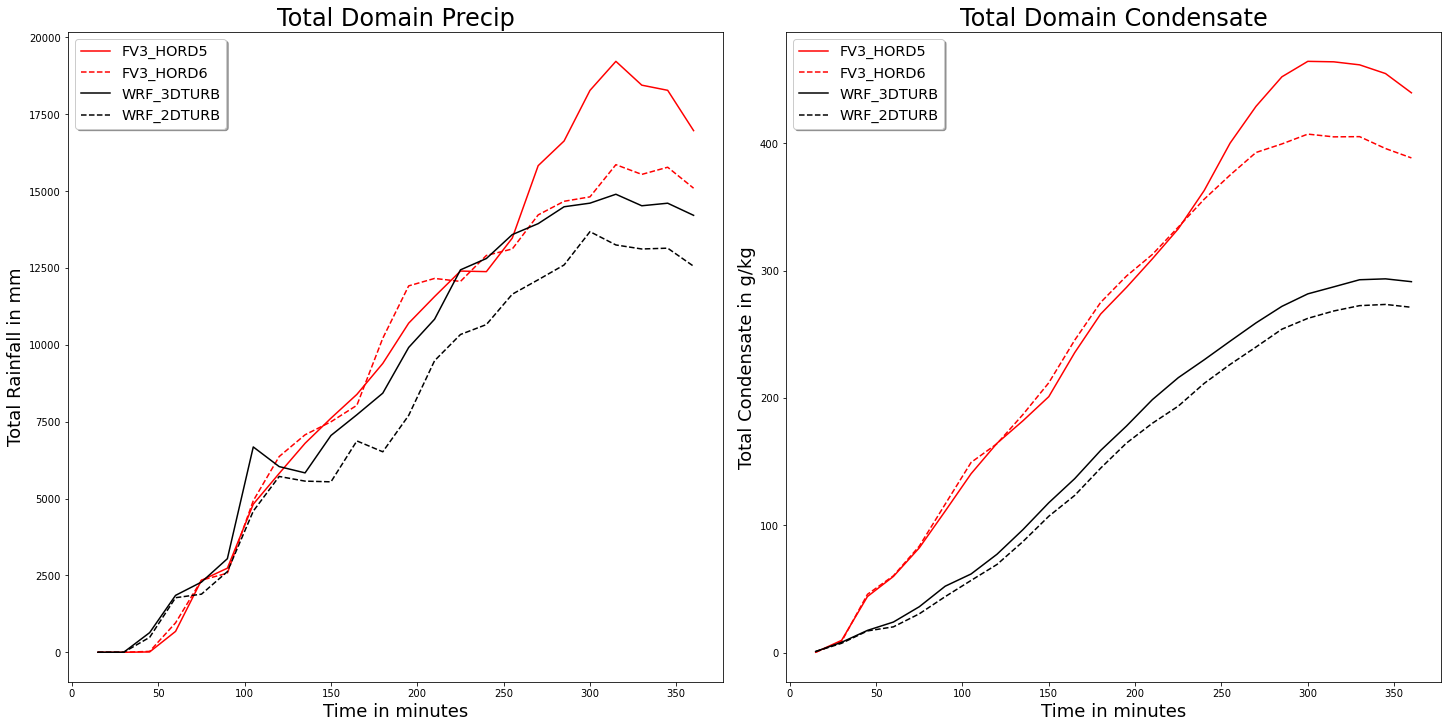

In [85]:
fig, ax = plt.subplots(1,2, constrained_layout=True,figsize=(20,10))

ax[0].plot(time, fv3A_total_precip, color='r', linestyle='-', label='FV3_HORD5')
ax[0].plot(time, fv3B_total_precip, color='r', linestyle='--', label='FV3_HORD6')

ax[0].plot(time, wrf3_total_precip, color='k', linestyle='-', label='WRF_3DTURB')
ax[0].plot(time, wrf4_total_precip, color='k', linestyle='--', label='WRF_2DTURB')

legend = ax[0].legend(loc='upper left', shadow=True, fontsize='x-large')
ax[0].set_title('Total Domain Precip', fontsize=24)
ax[0].set_xlabel('Time in minutes', fontsize=18)
ax[0].set_ylabel('Total Rainfall in mm', fontsize=18)

#

ax[1].plot(time, fv3A_cond_total, color='r', linestyle='-', label='FV3_HORD5')
ax[1].plot(time, fv3B_cond_total, color='r', linestyle='--', label='FV3_HORD6')

ax[1].plot(time, wrf3_cond_total, color='k', linestyle='-', label='WRF_3DTURB')
ax[1].plot(time, wrf4_cond_total, color='k', linestyle='--', label='WRF_2DTURB')

legend = ax[1].legend(loc='upper left', shadow=True, fontsize='x-large')
ax[1].set_title('Total Domain Condensate', fontsize=24)
ax[1].set_xlabel('Time in minutes', fontsize=18)
ax[1].set_ylabel('Total Condensate in g/kg', fontsize=18)

plt.savefig('SquallLine_precip_cond.png', dpi=300)


In [83]:
plt.savefig('SquallLine_precip_cond.png')

<Figure size 432x288 with 0 Axes>